#### https://www.jiqizhixin.com/articles/2018-01-14-8

## 揭秘python 中的模型集成
> 集成（ensemble）正在迅速成为应用机器学习最热门和流行的方法。目前，几乎每一个 Kaggle 冠军的解决方案都使用了集成，很多数据科学 pipeline 也使用集成。

>简单来说，集成把不同模型的预测结果结合起来，生成最终预测，集成的模型越多，效果就越好。另外，由于集成结合了不同的基线预测，它们的性能至少等同于最优的基线模型。集成使得我们几乎免费就获得了性能提升！


> 集成图示。输入数组 X 通过两个预处理 pipeline 输入至多个基学习器 f(i)。集成将所有的基学习器的预测结果结合起来，导出最终的预测数组 P。（图片来源：http://ml-ensemble.com/）

>本文介绍集成的基础知识：定义及工作原理，并提供构建基础集成的实践教程。阅读本文，你将：

>理解集成的基础知识；
了解如何编写集成；
理解集成的主要优缺点。

### 预测共和党和民主党的捐款
>在本文中，我们将使用美国政治捐款数据集来解释集成的工作原理。该数据集最初由 FiveThirtyEight 的 Ben Wieder 制作，他查阅美国政府的政治捐款记录，发现科学家向政治家们捐款时，通常会选择民主党。

>该论断基于向共和党和民主党捐款数额的比例。但是，我们还可以从中看出更多事情：比如，哪个学科最可能捐款给共和党，哪个州最可能捐款给民主党。我们将更进一步，预测捐款更可能的流向。

>此处使用的数据经过稍微修改（https://www.dataquest.io/blog/large_files/input.csv）。
>我们删除了捐款给共和党和民主党之外的其他党派的捐款信息，以使过程更加清晰，并且还去除了重复信息和不太有趣的特征。数据脚本地址：https://www.dataquest.io/blog/large_files/gen_data.py。
>数据如下：

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [78]:
SEED = 222
np.random.seed(SEED)
df = pd.read_csv("input.csv")
df.head()

,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [79]:
def get_train_test(test_size=0.95):
    
    """ split data into train and test sets"""

    y = 1* (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)

    X = pd.get_dummies(X, sparse=True)  ######
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)

    return train_test_split(X, y, test_size=test_size, random_state=SEED)

In [80]:
xtrain, xtest, ytrain, ytest = get_train_test()

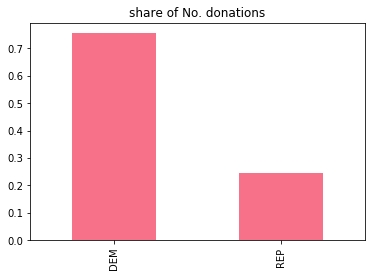

In [81]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(kind="bar", title="share of No. donations")
plt.show()

> 上图是 Ben 的论断的数据依据。确实，75% 的捐款是给民主党的。我们来看一下可以使用的特征，我们具备捐款人、交易详情和捐款接受者的数据信息：

![显示失败](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/566672.png)

>什么是集成？
想象一下你在玩常识问答游戏。一个人玩时，可能会有一些题你完全不了解。如果我们想获得高分，就需要组建一个团队来覆盖所有相关主题。这就是集成的基本概念：结合多个模型的预测，对特异性误差取平均，从而获得更好的整体预测结果。

>一个重要问题是如何结合预测。以常识问答游戏为例，我们很容易想象到团队成员可能会使用多数投票的方式确定选择哪个答案。机器学习的分类问题也是一样：作出最常见的类别标签预测相当于多数投票规则。但是也有很多其他方式可以结合预测，通常我们会使用一个模型来学习如何最好地结合预测结果。


>通过决策树理解集成
我们用一个简单的可解释性模型来解释集成：使用 if-then 规则的决策树。决策树越深，可以捕捉的模式就越复杂，不过也更有可能出现过拟合。因此，我们需要另一种方式来构建决策树的复杂模型，而不同决策树的集成就是这样一种方式。

>我么使用下列辅助函数来可视化决策树：

In [82]:
import pydotplus  # you can install pydotplus with: pip install pydotplus 

from IPython.display import Image

from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [83]:
def print_graph(clf, feature_names):

    """Print decision tree."""

    graph = export_graphviz(

        clf,

        label="root",

        proportion=True,

        impurity=False, 

        out_file=None, 

        feature_names=feature_names,

        class_names={0: "D", 1: "R"},

        filled=True,

        rounded=True

    )

    graph = pydotplus.graph_from_dot_data(graph)  

    return Image(graph.create_png())

### 在训练数据上用决策树拟合一个节点（决策规则），查看它在测试集上的性能：

Decision tree ROC_AUC score: 0.672


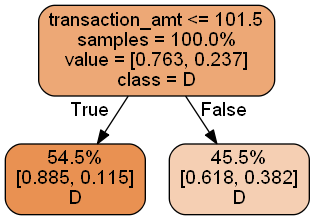

In [84]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)

p = t1.predict_proba(xtest)[:,1]
print("Decision tree ROC_AUC score: %.3f" %(roc_auc_score(ytest, p)))
print_graph(t1, xtrain.columns)

>决策树的 ROC-AUC 得分：0.672

>每个叶节点记录它们在训练样本中的比例、类别分布和类别标签预测。我们的决策树根据捐款金额是否超过 101.5 进行预测：它竟然作出了同样的预测！鉴于 75% 的捐款都给了民主党，这个结果并不令人惊讶。但是这没有充分利用我们已有的数据，下面我们使用三层决策规则，看看会得到什么：

Decision tree ROC-AUC score: 0.751


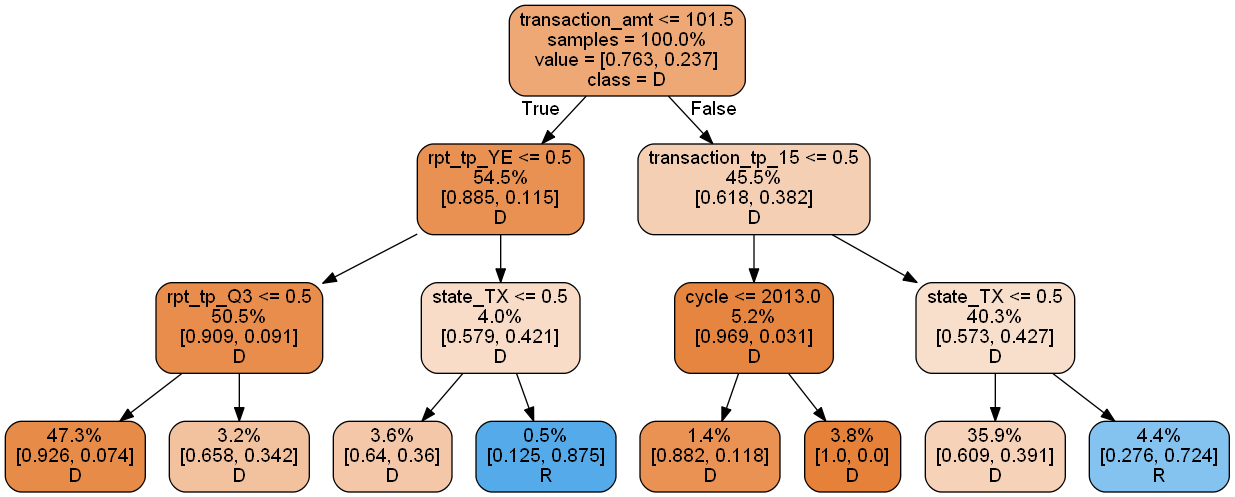

In [85]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)

t2.fit(xtrain, ytrain)

p = t2.predict_proba(xtest)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

print_graph(t2, xtrain.columns)

> 决策树的 ROC-AUC 得分：0.751

>该模型并不比简单的决策树好太多：预测到的共和党捐款金额比例只有 5%，远远低于 25%。仔细观察会发现该决策树使用了很多不确定的分割规则（splitting rule）。观察结果中高达 47.3% 的结果在最左边的叶节点中，而 35.9% 在右二的叶节点中。因此大量叶节点没有关联。使该模型更深只会导致过拟合。

>在深度固定的情况下，决策树可以通过增加「宽度」的方式来增加复杂度，即创建多个决策树，并将其连接起来。也就是决策树的集成。想了解这个集成模型为什么会起作用，先要考虑我们如何让决策树探索出比上层树更多的其他模式。最简单的解决方案就是删除树中较早出现的特征。假如我们删除了转账金额特征（transaction_amt），树的根节点，则新的决策树如下：

Decision tree ROC-AUC score: 0.740


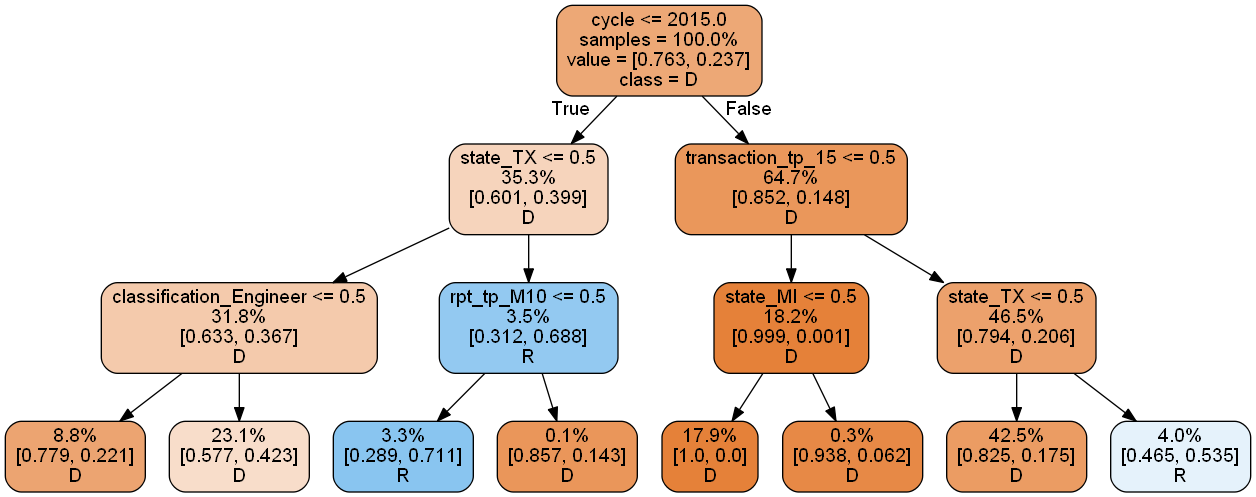

In [86]:
drop = ["transaction_amt"]
xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)

p = t3.predict_proba(xtest_slim)[:,1]
print('Decision tree ROC-AUC score: %.3f' %(roc_auc_score(ytest, p)))
print_graph(t3, xtrain_slim.columns)

> 决策树的 ROC-AUC 得分：0.740

>ROC-AUC 得分与上树得分类似，但是共和党捐款比例增加至 7.3%。还是很低，但比之前稍高一些。重要的是，与第一个树相反（第一个树大部分规则与转账本身相关），这棵树更专注于候选人的居住地。现在我们有两个模型，二者预测能力相近，但基于不同的规则运行。因此，它们可能出现不同的预测误差，我们可以使用集成方法取其平均数。

>如果集成包含两个以上决策树，则它根据多数原则进行预测。因此，集成对分类器预测结果取平均又叫作多数投票分类器（majority voting classifier）。当集成基于概率取平均时，我们称其为软投票，而对类别标签预测结果取平均被成为硬投票。

>当然，集成不是万能的。你可能注意到上述示例中，取平均有效的前提是预测误差必须不相关。如果两个模型都作出了错误的预测，则集成无法作出进行修正。此外，在软投票机制中，如果一个模型作出了错误的预测，但概率值较高，则集成可能会作出错误的判断。通常，集成无法使每个预测都正确，但是预计其性能优于底层模型。



### 森林是树的集成

>回到我们的预测问题，看看我们是否可以用两个决策树构建一个集成。首先检查误差关联性：高度关联的误差会造成差的集成。

In [87]:
p1 = t2.predict_proba(xtest)[:, 1]

p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({"full_data": p1,

              "red_data": p2}).corr()  ###############

,full_data,red_data
full_data,1.000000,0.669128
red_data,0.669128,1.000000


>有一些关联性，但不过分：预测方差仍有很大的利用空间。为了构建该集成，我们简单地平均了两个模型的预测。

In [88]:
p1 = t2.predict_proba(xtest)[:, 1]

p2 = t3.predict_proba(xtest_slim)[:, 1]

p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" %(roc_auc_score(ytest, p)))

Average of decision tree ROC-AUC score: 0.783


> 确实，集成步骤导致分值增加。但是如果我们有更多不同的树，我们甚至可以得到更大的分值。在设计决策树时，我们应该去除哪些特征？

>一个快速有效的实践方法是随机地选择一个特征子集，在每个 draw 上拟合一个决策树并平均其预测。这一过程被称为自举平均（bootstrapped averaging，通常缩写为 bagging），它应用于决策树所产生的模型是随机森林。让我们看看随机森林能为我们做什么。我们使用 Scikit-learn 实现构建了 10 个决策树的集成，每一个拟合包含 3 个特征的子集。

In [89]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
            n_estimators=10,
            max_features=3,
            random_state=SEED)
rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:,1]
print("Average of Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of Decision tree ROC-AUC score: 0.844


> 目前为止，我们看到了集成的两个重要方面：

1. 预测误差的关联性越低，效果越好

2. 模型越多，效果越好

> 涵盖的模型没有限制：决策树、线性模型、核模型、非参数模型、神经网络，或者甚至其他集成！记住我们包含的模型越多，集成的速度就会越慢。

>为了构建不同模型的集成，我们首先在数据集上对一组 Scikit-learn 分类器进行基准测试。为了避免代码重复，我们使用下面的辅助函数：

In [90]:
from sklearn.svm import SVC, LinearSVC

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.kernel_approximation import Nystroem

from sklearn.kernel_approximation import RBFSampler

from sklearn.pipeline import make_pipeline

In [91]:
def get_models():
    
    """Generate a library of base learner"""
    
    nb = GaussianNB()
    
    svc = SVC(C=100, probability=True)

    knn = KNeighborsClassifier(n_neighbors=3)

    lr = LogisticRegression(C=100, random_state=SEED)

    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)

    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)

    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)
    
    models = {'svm': svc,

              'knn': knn,

              'naive bayes': nb,

              'mlp-nn': nn,

              'random forest': rf,

              'gbm': gb,

              'logistic': lr,

              }

    return models

In [92]:
def train_predict(model_list):

    """Fit models in list on training set and return preds"""

    P = np.zeros((ytest.shape[0], len(model_list)))

    P = pd.DataFrame(P)


    print("Fitting models.")

    cols = list()

    for i, (name, m) in enumerate(models.items()):

        print("%s..." % name, end=" ", flush=False)

        m.fit(xtrain, ytrain)

        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]

        cols.append(name)

        print("done")


    P.columns = cols

    print("Done.\n")

    return P



def score_models(P, y):

    """Score model in prediction DF"""

    print("Scoring models.")

    for m in P.columns:

        score = roc_auc_score(y, P.loc[:, m])

        print("%-26s %.3f" % (m, score))

    print("Done.\n")

> 我们现在正准备创建一个预测矩阵 P，其中每个特征对应于由给定模型做出的预测，并根据测试集为每个模型评分：

In [93]:
models = get_models()

p = train_predict(models)

score_models(p, ytest)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done
Done.

Scoring models.
svm                        0.850
knn                        0.779
naive bayes                0.803
mlp-nn                     0.851
random forest              0.844
gbm                        0.878
logistic                   0.857
Done.



> 这是我们的基线。梯度提升机（Gradient Boosting Machine/GBM）效果最好，其次是简单的 logistic 回归。对于我们的集成策略来说，预测误差必须是相对不关联的。

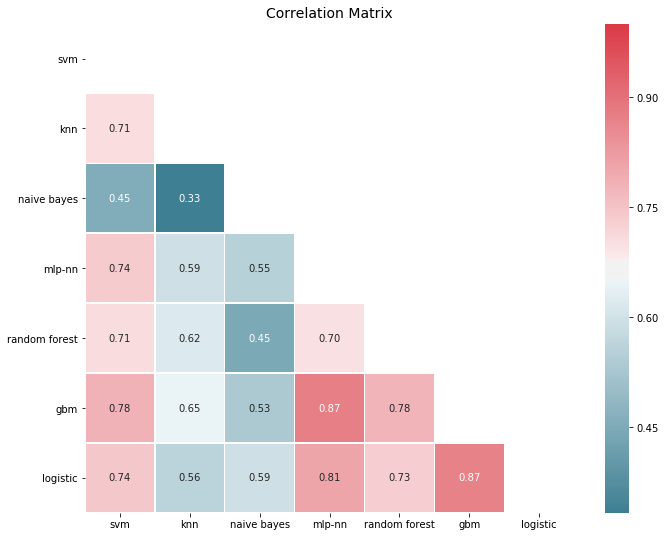

In [94]:
from mlens.visualization import corrmat


corrmat(p.corr(), inflate=False)

plt.show()

>误差明显关联，这对于表现良好的模型是可以预期的，因为它是典型的异常值，很难纠正。然而，大多数关联性在 50-80％的范围内，所以还有很大的改进余地。事实上，如果我们从类别预测的角度看误差关联性，事情看起来会更有希望：

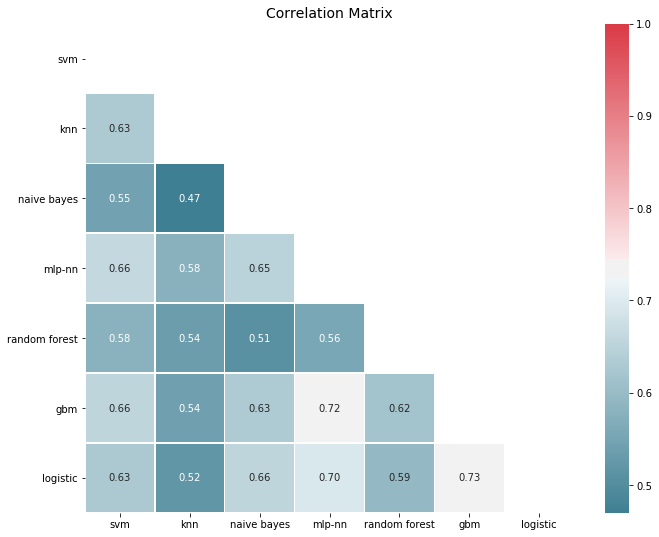

In [95]:
corrmat(p.apply(lambda pred: 1*(pred >= .5) - ytest.values).corr(), inflate=False)
plt.show()

>为了创建集成，我们继续并进行平均预测，正如我们所期望的，集成的性能要好于基线。平均化是一个简单的过程，如果我们存储模型预测，我们可以从一个简单的集成开始，并在训练新模型时随时增加其大小。

In [96]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p.mean(axis=1)))

Ensemble ROC-AUC score: 0.884


### 可视化集成的工作过程

>我们已经对集成的误差关联机制有所了解。这意味着集成通过平均谬误可以平滑决策边界。决策边界向我们表明评估器如何将特征空间分割成邻域，其中所有的观察结果被预测为具有相同的分类标签。通过平均基学习器决策边界，集成被赋予更平滑的边界，泛化也更自然。

>下图展示了这一点。这里的实例是鸢尾花数据集，其中评估者试图对三种花进行分类。基学习器在其边界都有一些不良的特性，但是这个集成有一个相对平滑的决策边界，与观察结果一致。令人惊讶的是，集成既增加了模型的复杂度，也起到了正则化项的作用！

![显示失败](https://image.jiqizhixin.com/uploads/wangeditor/c897487a-bf02-4023-9355-24c747d7ef62/20515image%20(9).png)

>当任务是分类时，另一种理解集成的方式是检查 ROC 曲线（Receiver Operator Curve），它向我们展示了评估者如何进行精确率和召回率之间的权衡。通常，不同的基学习器做出不同的权衡：一些通过牺牲召回率实现更高的精确率，另一些则相反。

>另一方面，对于每个训练点，非线性元学习器可以调整其依赖的模型。这意味其可以极大地减少不必要的牺牲，并在增加召回率的同时保持高精确率（反之亦然）。下图中，集成在精确率上做了一个更小的牺牲，以增加召回率。



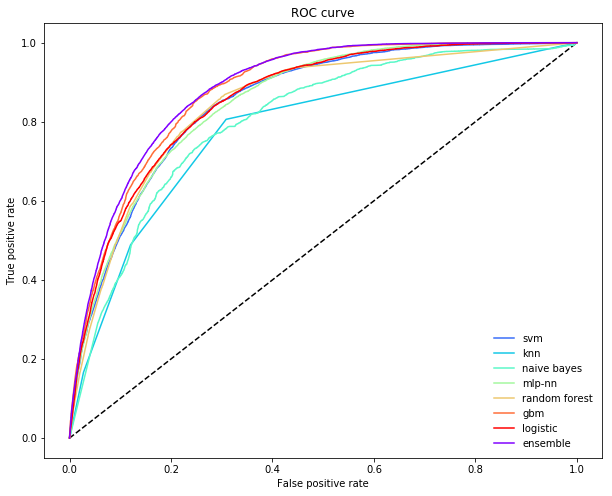

In [97]:
from sklearn.metrics import roc_curve


def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):

    """Plot the roc curve for base learners and ensemble."""

    plt.figure(figsize=(10, 8))

    plt.plot([0, 1], [0, 1], 'k--')


    cm = [plt.cm.rainbow(i)

      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]


    for i in range(P_base_learners.shape[1]):

        p = P_base_learners[:, i]

        fpr, tpr, _ = roc_curve(ytest, p)

        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])


    fpr, tpr, _ = roc_curve(ytest, P_ensemble)

    plt.plot(fpr, tpr, label=ens_label, c=cm[0])


    plt.xlabel('False positive rate')

    plt.ylabel('True positive rate')

    plt.title('ROC curve')

    plt.legend(frameon=False)

    plt.show()



plot_roc_curve(ytest, p.values, p.mean(axis=1), list(p.columns), "ensemble")

### 超越简单平均值的集成
>但是在预测误差变动一定的情况下，你不会期望更多的提升吗？一些模型表现要比其他模型相对糟糕，但是其影响一样大。这对不平衡数据集来说是毁灭性的：如果一个模型做出极端预测（即接近于 0 或 1），则通过软投票召回，因为其对预测平均值有极大的影响。

>对我们来说，一个重要的因素是模型是否可以捕捉到共和党所收捐款的全部比例。一个简单的检查表明所有模型对共和党捐款比例的预测都过低，其中一些相对更糟。

In [100]:
p = p.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))


p.index = ["DEM", "REP"]

p.loc["REP", :].sort_values().plot(kind="bar")

plt.axhline(0.25, color="k", linewidth=0.5)

plt.text(0., 0.23, "True share republicans")

plt.show()

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements